In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential,Model 
from keras.layers.core import Dense,Dropout,Activation,Flatten,Reshape
from keras.layers import Embedding,Input ,merge, ELU
from keras.layers.recurrent import SimpleRNN , LSTM 
from keras.layers.convolutional import Convolution2D , MaxPooling2D
from keras.optimizers import SGD ,Adam,RMSprop
from keras.regularizers import l2,l1
from keras.utils.np_utils import to_categorical 
from keras import backend as K
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [3]:
from keras.layers.convolutional import MaxPooling2D 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import TensorBoard, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from keras.layers import GlobalMaxPooling2D
import tensorflow.keras
import math
import numpy as np

In [4]:
import glob #grab some files 
from tqdm import tqdm # to look at progress bars
import scipy # Used for image processing 
import scipy.misc
import pandas as pd
import h5py as hp


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
data=np.load('/content/drive/My Drive/Cam/data_set_2.npz')
X_tr=data['X_train_imgs']
X_ts=data['X_test_imgs']
y_tr=data['y_train']
y_ts=data['y_test']
print(X_tr.shape)
print(y_tr.shape)

(50144, 3, 80, 80)
(50144, 5)


In [7]:
data_1=np.load('/content/drive/My Drive/Cam/data_set.npz')
X_train_imgs=np.array(data_1['img_train'])

X_test_imgs=np.array(data_1['img_test'])
spds_t=data_1['spds']
accel_t=data_1['accel']
speedx=np.column_stack((data_1['spds'],data_1['accel']))
#speedx=speedx.reshape((-1,2))
steer_t=data_1['steer']
gas_t=data_1['gas']
brake_t=data_1['brake']
print(brake_t.shape)
print("brake= ",brake_t)
#y1=np.concatenate(speedx,steer_t)
#y_t=y_t.reshape((2,-1))
y1=np.column_stack((data_1['steer'],data_1['gas']))   #,data_1['brake'])
#y1=y1.reshape(-1,2)
y2=np.column_stack((speedx,y1))
#y2=y2.reshape(-1,4)
y_t=np.column_stack((y2,brake_t))
#y_t=y_t.reshape((-1,5))
#print(steer_t)
#print(speedx[10:20])
#print(" \n X_t",X_t)

y_train=np.array(y_t[0:X_train_imgs.shape[0],:])
y_test=np.array(y_t[X_train_imgs.shape[0]+1:-1,:])

print("y_t shape: ",y_train.shape)
print("\n y_t",y_train[2300:2307]) # Checking 7 examples
print("\n X_train_imgs shape :",X_train_imgs.shape)
#np.reshape(X_t,X_t.shape[0],X_t.shape[2],X_t.shape[3],X_t.shape[1])
#print("\n X_t shape is now changed as per tf style :",X_t.shape)

#print("\n ",brake_t)  /content/data_set.npz


(51691,)
brake=  [1.         1.         1.         ... 0.0290702  0.02920806 0.02902903]
y_t shape:  (46521, 5)

 y_t [[0.16156293 0.74701743 0.3056136  0.         0.001001  ]
 [0.16318153 0.73305503 0.31748482 0.         0.001001  ]
 [0.1641239  0.71519124 0.32833201 0.         0.001001  ]
 [0.16522524 0.71633724 0.33838807 0.         0.00103667]
 [0.16640975 0.69481105 0.34753177 0.         0.0015015 ]
 [0.1679955  0.71378346 0.35614275 0.         0.0015015 ]
 [0.16945684 0.69844973 0.36494135 0.         0.0015015 ]]

 X_train_imgs shape : (46521, 3, 80, 80)


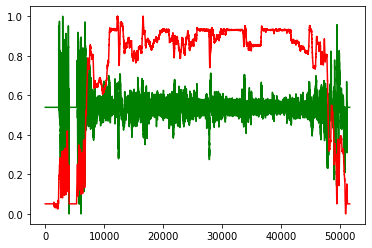

In [8]:
import matplotlib.pyplot as plt


plt.plot(accel_t,color='green')
plt.plot(spds_t,color='red')


(96665, 3, 80, 80)
(96665, 5)


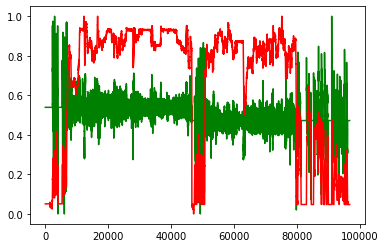

In [9]:
X_train_imgs_t=np.concatenate((X_train_imgs,X_tr))
y_train_t=np.concatenate((y_train,y_tr))
X_test_t=np.concatenate((X_test_imgs,X_ts))
y_test_t=np.concatenate((y_test,y_ts))
print(X_train_imgs_t.shape)
print(y_train_t.shape)
plt.plot(y_train_t[:,1],color='green')
plt.plot(y_train_t[:,0],color='red')


In [10]:
del X_train_imgs
del X_tr
del y_train 
del y_test
del y1,y2,y_t


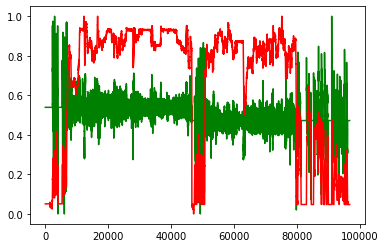

In [11]:

spds_train=y_train_t[:,0]
spds_test=y_test_t[:,0]
steer_train=y_train_t[:,2]
steer_test=y_test_t[:,2]

accel_train=y_train_t[:,1]
accel_test=y_test_t[:,1]
gas_train=y_train_t[:,3]
gas_test=y_test_t[:,3]
brake_train=y_train_t[:4]
brake_test=y_train_t[:4]

plt.plot(accel_train,color='green')
plt.plot(spds_train,color='red')

In [12]:
import keras.backend.tensorflow_backend as tfback
def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

In [13]:
def make_model(X,Y):
    model=Sequential()
              #model.add(Dense(10,activation='relu')) #input layer
    model.add(Convolution2D(128,3,input_shape=(3,80,80),activation='relu',data_format='channels_first')) #1st conv layer
    model.add(MaxPooling2D())       #pool_size=(2,2),data_format='channels_last'
    #x=modl(inputs)                  #add model layers
                      #model.add(Conv2D(64, kernel_size=3, activation=’relu’, input_shape=(28,28,1)))
    model.add(Convolution2D(256,3,activation='relu'))
    model.add(MaxPooling2D())
    """ model.add(Convolution2D(256,(3,3),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(256,(3,3),activation='relu'))
    model.add(MaxPooling2D())"""
    #model.add(Dropout(0.2))
    #x=modl(inputs)           #pool_size=(2,2),data_format='channels_first
    model.add(Convolution2D(256,3,activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    #x=modl(inputs)     #pool_size=(2,2),data_format='channels_first'
    model.add(Convolution2D(128,3,activation='relu'))
    model.add(MaxPooling2D())
    #model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
    #model.add(Convolution2D(128,(3,3),activation='relu'))
    # model.add(MaxPooling2D()) 
    #model.add(Dropout(0.2))
    #x=modl(inputs)        #
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.1))
    #x=modl(inputs)
    model.add(Dense(64, activation='relu'))
    #x=modl(inputs)
    model.add(Dense(5,activation='linear'))
    #model= Model(inputs=inputs,outputs=outputs)
    print(model.summary())
    model.compile(loss='mae',optimizer='adam', metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(X,Y, batch_size=500, epochs=50, validation_split=0.15)
    return history

In [14]:
Full_control=make_model(X_train_imgs_t,y_train_t)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 78, 78)       3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 39, 78)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 37, 256)       179968    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 18, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 8, 256)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 8, 256)       

0.19198845

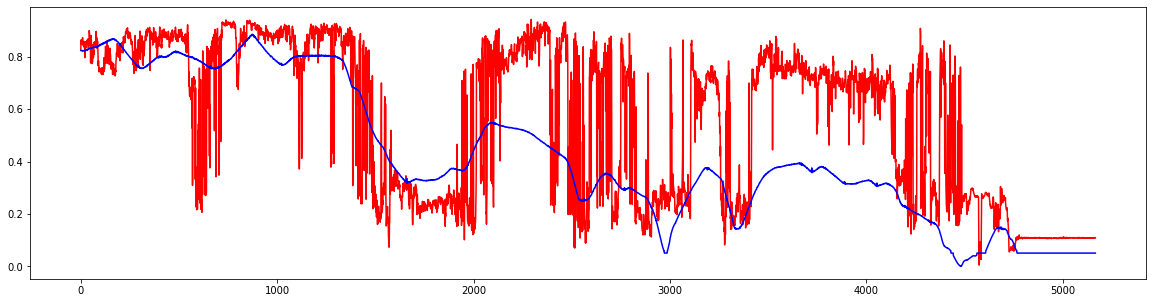

In [15]:
# speed , acceleration , steer ,gas ,brake 
y_pred=Full_control.model.predict(X_test_imgs)

plt.rcParams["figure.figsize"] = (20,5)

plt.plot(y_pred[:,0],color='red',label='speed_pred')  #speed
plt.plot(spds_test,color='blue',label='speed_true')

mae = tf.keras.losses.MeanAbsoluteError()
mae(spds_test, y_pred[:,0]).numpy()

#plt.ylabel('speed_true')



0.11293922

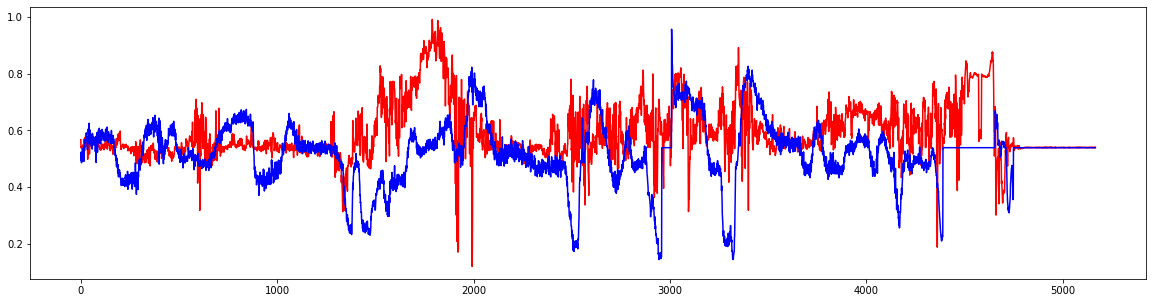

In [16]:
plt.plot(y_pred[:,1],color='red') #accel
plt.plot(accel_test,color='blue')
mae(accel_test, y_pred[:,1]).numpy()

0.05017294

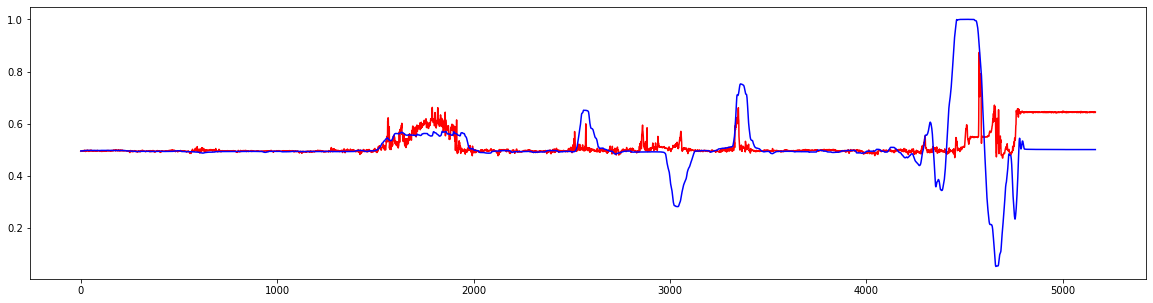

In [22]:
plt.plot(y_pred[:,2],color='red') #steer
plt.plot(steer_test,color='blue')
mae(steer_test, y_pred[:,2]).numpy()

0.39129427

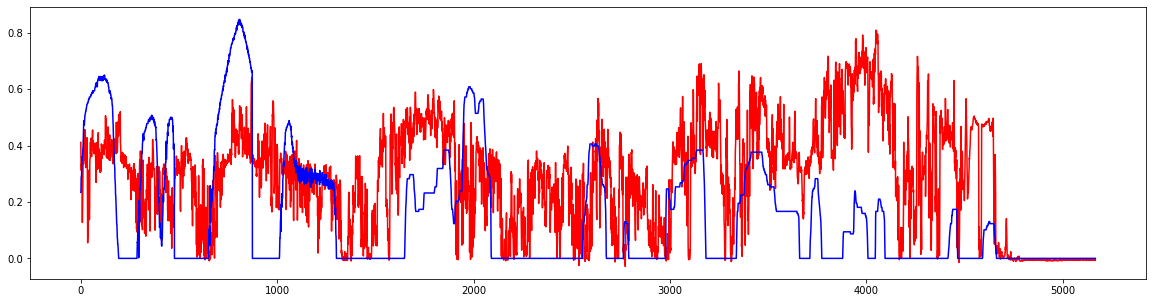

In [23]:
plt.plot(y_pred[:,3],color='red') # Gas
plt.plot(gas_test,color='blue')
mae(gas_test, y_pred[:,2]).numpy()

InvalidArgumentError: ignored

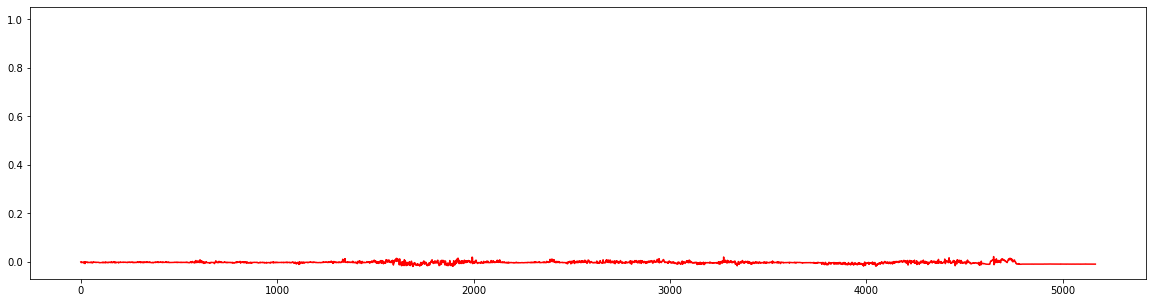

In [24]:
plt.plot(y_pred[:,4],color='red') #brake
plt.plot(brake_test,color='blue')
mae(brake_test,y_pred[:,2]).numpy()

In [20]:
mae = tf.keras.losses.MeanAbsoluteError()
mae(y_test_t,y_pred).numpy()

0.118219025

In [21]:
Full_control.model.save("Full_control_model.h5py")
!cp "/content/Full_control_model.h5py"  "/content/drive/My Drive/Cam/Full_control_model.h5py"